# Peak Detection Experiment Notebook

### Imports

In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/MyDrive/SG_Work/Displacement_metrics
%ls

Mounted at /gdrive
/gdrive/MyDrive/SG_Work/Displacement_metrics
 20220830_S53_rawDataLeft_vuQAzlAArG_results.csv   Distance_Analysis.ipynb
 20220830_S55_rawDataLeft_vuQAzlAArG_results.csv   main.py
 20220830_S57_rawDataLeft_vuQAzlAArG_results.csv   notebook.html
 20220830_S59_rawDataLeft_vuQAzlAArG_results.csv  'Peak Detection.ipynb'
 data/                                             Steps-Analysis.zip
 Distance_Analysis.html                            utils/


In [3]:
from json import load
import numpy as np
from utils.data_loader import load_data, convert_signal
from utils.normalisation import min_max
import matplotlib.pyplot as plt
import pandas as pd
import os 

# Data Loading and transformation

In [4]:
path = f"./data"
root = './data'
file_list = []
for file in os.listdir(root):
    file_list.append(os.path.join(root, file))

print('Files found: ', file_list)

Files found:  ['./data/20220830_S60_rawDataLeft_vuQAzlAArG.txt', './data/20220830_S60_rawDataRight_vuQAzlAArG.txt', './data/20220830_S59_rawDataRight_vuQAzlAArG.txt', './data/20220830_S59_rawDataLeft_vuQAzlAArG.txt', './data/20220830_S55_rawDataLeft_vuQAzlAArG.txt', './data/20220830_S55_rawDataRight_vuQAzlAArG.txt', './data/20220830_S53_rawDataLeft_vuQAzlAArG.txt', './data/20220830_S53_rawDataRight_vuQAzlAArG.txt', './data/20220830_S57_rawDataLeft_vuQAzlAArG.txt', './data/20220830_S57_rawDataRight_vuQAzlAArG.txt', './data/Raw Data Info.txt']


The idea of the current algorithm is to look at the gyroscope data to see the curves on each axis and to determine which gyroscope axis represents the strides well enough to use for segmentation.

Segmentation will work in the following way:

1. Determine the most relevant axis that represents the rotation of the foot when it is swinging.
2. Use the differential of the signal (positive and negative rotation)
3. Binarise the differential
4. Find the change of the binary data as well.
5. Count the indexes from peak to peak.

In [5]:
data = load_data(file_list[0:8]) # Select only the data instances

# Convert the signals 
acc_data = []
for sample in data: 
    signal = convert_signal(sample, type='acc_total')
    signal = signal.to_numpy()
    acc_data.append(signal.tolist())

# Gyroscope is going to be calculated with the axis on their own.
gyro_data = [] 
for sample in data: 
    signal = convert_signal(sample, type='gyro')
    # signal = signal.to_numpy()
    gyro_data.append(signal)


./data/20220830_S60_rawDataLeft_vuQAzlAArG.txt
./data/20220830_S60_rawDataRight_vuQAzlAArG.txt
./data/20220830_S59_rawDataRight_vuQAzlAArG.txt
./data/20220830_S59_rawDataLeft_vuQAzlAArG.txt
./data/20220830_S55_rawDataLeft_vuQAzlAArG.txt
./data/20220830_S55_rawDataRight_vuQAzlAArG.txt
./data/20220830_S53_rawDataLeft_vuQAzlAArG.txt
./data/20220830_S53_rawDataRight_vuQAzlAArG.txt


# Analysing Gyroscope Data

Text(0, 0.5, 'Amplitude Z')

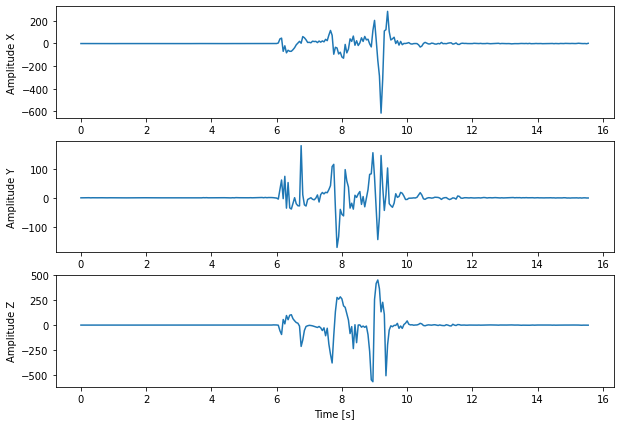

In [6]:
sample = 3
time = 0.05 * gyro_data[sample].index
plt.figure(figsize=[10,7])
# -----------------------------------------
plt.subplot(3,1,1)
plt.plot(time, gyro_data[sample]['gyro_x'])
plt.ylabel('Amplitude X')
# -----------------------------------------
plt.subplot(3,1,2)
plt.plot(time, gyro_data[sample]['gyro_y'])
plt.ylabel('Amplitude Y')
# -----------------------------------------
plt.subplot(3,1,3)
plt.plot(time, gyro_data[sample]['gyro_z'])
plt.xlabel('Time [s]')
plt.ylabel('Amplitude Z')

The graph represents the amplitudes of each axis. This indicates that the gyroscope in the Z axis experiences the most prominent rotation with a 1000 amplitude change.

We now have to build the next segment of the peak detection algorithm. 

1. Select the Z axis of rotation of the gyroscope.
2. Calculate the `threshold` for the current data sample:
    - The `threshold` is calculated by isolating the positive data of the gyroscope rotation. This assumption is necessary to obscure noise and capture only progressive rotation of the gyroscope which indicates actual movement.
    - If the `threshold` is exceeded, that would mean that the foot is in motion at that moment in time.
3. Using the `threshold` create a binary data array which will indicate the step `start` and `end`.
4. Differentiate the binary array to get the actual indexes of the `start` and `end` of a step. 
    - Note: This currently isnt used, but will be useful for further exploration.


In [46]:
x = gyro_data[sample].gyro_z # This is the same as selecting gyro_data[sample]['gyro_z']
t = x[list(x.map(lambda i: i > 0))].mean() # This is unecessarily complicated programming, but the idea is simple
# t = [i for i in x if i > 0] # this is better than ^ but then we have to get the average differently
binary = np.zeros(len(x))
binary[x > t] = 1.0
boolean_peaks = list(map(lambda i: True if i > 0 else False, binary)) # create a True and False instead of 1 and 0

peaks = np.diff(binary)


Todo: check how close the peaks are and fill in between. (assuming that the step continues.)

Text(0.5, 0, 'Time[s]')

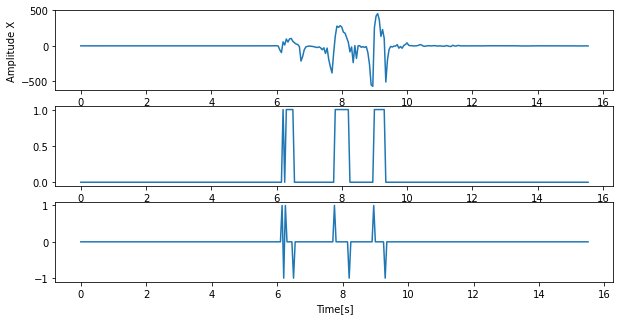

In [8]:
plt.figure(figsize=(10,5))
plt.subplot(3,1,1)
plt.plot(time, x)
plt.ylabel('Amplitude X')
# -----------------------------------------
plt.subplot(3,1,2)
plt.plot(time, binary)
# -----------------------------------------
plt.subplot(3,1,3)
plt.plot(time[:-1], peaks) # -1 is necessary since diff produces 1 less the length
plt.xlabel('Time[s]')

Now we have to load the distance data (or calculate the distance again for this specific sample. 

Then we can apply the peaks `(where x == 1)` to calculate the distance taken from the start of the step `(x == 1)` and potentially the end of the step `(x == -1)`.

# Calculating distance

- First we have to load the correct data set with distance. (Or recalculate it from the raw data.) 
- Suprimpose the binary array and cumulatively sum up all the distance values from the distance array.
- When a step finishes reset the cumulation to 0 and perform the same calculation for the next step.


In [9]:
%ls # check the files and load the current one.

 20220830_S53_rawDataLeft_vuQAzlAArG_results.csv   Distance_Analysis.ipynb
 20220830_S55_rawDataLeft_vuQAzlAArG_results.csv   main.py
 20220830_S57_rawDataLeft_vuQAzlAArG_results.csv   notebook.html
 20220830_S59_rawDataLeft_vuQAzlAArG_results.csv  'Peak Detection.ipynb'
 data/                                             Steps-Analysis.zip
 Distance_Analysis.html                            utils/


In [62]:
df = pd.read_csv('20220830_S59_rawDataLeft_vuQAzlAArG_results.csv')
time = df.index * 0.05 # Reset the time variable to re-draw the plots
df.head()

,Unnamed: 0,acc_left,vel_left,dist_left,acc_right,vel_right,dist_right
0,0,-0.067441,0.000000,0.000000,-9.810000,0.000000,0.000000
1,1,-0.071300,-0.006937,-0.000347,-0.171426,-0.499071,-0.024954
2,2,-0.076863,-0.007755,-0.000752,-0.163278,-0.041689,-0.028286
3,3,-0.060413,-0.007252,-0.000788,-0.157045,-0.018101,-0.004404
4,4,-0.066406,-0.006704,-0.000737,-0.166305,-0.017073,-0.001979


Text(0.5, 0, 'Time[s]')

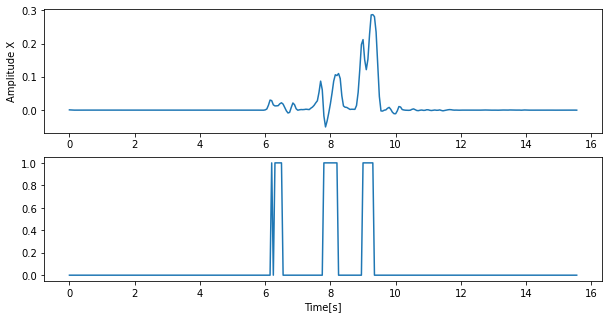

In [60]:
plt.figure(figsize=(10,5))
plt.subplot(2,1,1)
plt.plot(time, df.dist_left)
plt.ylabel('Amplitude X')
# -----------------------------------------
plt.subplot(2,1,2)
plt.plot(time[:-3], binary) # here it depends how off the axis is. In this case -4
plt.xlabel('Time[s]')

In [37]:
dist = df.dist_left.dropna()
print(f'Total Distance: {sum(dist)}')

Total Distance3.379507369249977


In [51]:
s = 0
cumulation = []
for i in range(len(dist)):
    if boolean_peaks[i]:
        cumulation.append(s + dist[i])
        s = dist[i]
    else:
        cumulation.append(s)
        s = 0

Text(0.5, 0, 'Time[s]')

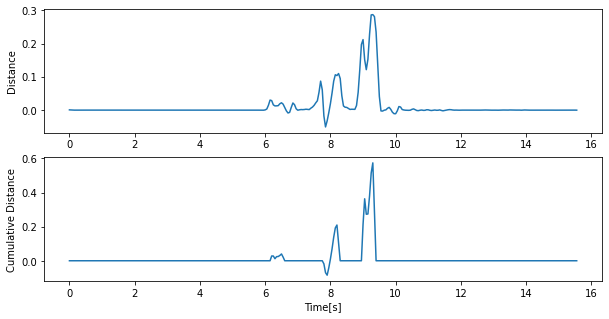

In [63]:
plt.figure(figsize=(10,5))
plt.subplot(2,1,1)
plt.plot(time, df.dist_left)
plt.ylabel('Distance')
# -----------------------------------------
plt.subplot(2,1,2)
plt.plot(time[:-3], cumulation) # here it depends how off the axis is. In this case -4
plt.ylabel('Cumulative Distance')
plt.xlabel('Time[s]')

In [57]:
sum(cumulation)

3.5962312569256216

# Add the new datapoints to the file.

In [66]:
df['motion_left'] = pd.Series(boolean_peaks)
df['dist_per_step_left'] = pd.Series(cumulation)

df.to_csv('20220830_S59_vuQAzlAArG_results.csv')